<a href="https://colab.research.google.com/github/evgenii-nikishin/omd/blob/main/tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis of Optimal Model Design (OMD) for the Tabular Case

We recommend running the notebook in Google Colab to have all the dependencies installed.

In [ ]:
!pip install git+https://github.com/gehring/fax

In [ ]:
import hypothesis.extra.numpy
import hypothesis.strategies
from functools import partial
import numpy as np
from tqdm import tqdm
from tabulate import tabulate
import time

import jax.numpy as jnp
import jax.test_util
from jax import random
from jax import tree_util
from jax.config import config
from jax.experimental import optimizers
from jax.experimental.stax import softmax
from jax.scipy.special import logsumexp
from jax.lax import cond

from fax import converge
from fax import test_util
from fax.constrained import implicit_ecp, cga_ecp

config.update("jax_enable_x64", True)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = (4.8, 3.6)
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.formatter.offset_threshold'] = 1
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.grid'] = True

## Defining the MDP

The experiments use a 2 state, 2 action MDP described in [The Value Function Polytope in Reinforcement Learning](https://arxiv.org/abs/1901.11524) (Appendix A, part d).

In [ ]:
# based on https://github.com/gehring/fax/blob/master/fax/constrained/constrained_test.py

true_transition = jnp.array([[[0.7, 0.3], [0.2, 0.8]],
                            [[0.99, 0.01], [0.99, 0.01]]])
true_reward = jnp.array(([[-0.45, -0.1],
                          [0.5, 0.5]]))
initial_distribution = jnp.ones(2) / 2
temperature = 0.01
true_discount = 0.9


optimal_value = 1.0272727  # pre-computed
kwargs = {'max_iter': 10000, 'lr_func': 0.01, 'optimizer': optimizers.adam}

def smooth_bellman_optimality_operator(x, params):
  transition, reward, discount, temperature = params
  return reward + discount * jnp.einsum('ast,t->sa', transition, temperature *
                                        logsumexp((1. / temperature) * x, axis=1))

@jax.jit
def objective_returns(x, params):
  del params
  policy = softmax((1. / temperature) * x)
  ppi = jnp.einsum('ast,sa->st', true_transition, policy)
  rpi = jnp.einsum('sa,sa->s', true_reward, policy)
  vf = jnp.linalg.solve(jnp.eye(true_transition.shape[-1]) - true_discount * ppi, rpi)
  return initial_distribution @ vf

@jax.jit
def objective_bellman(x, params):
  return -np.mean(true_constraints(x, params) ** 2)

@jax.jit
def true_constraints(x, params):
  del params
  params = (true_transition, true_reward, true_discount, temperature)
  return smooth_bellman_optimality_operator(x, params) - x

@jax.jit
def bellman_update(x, params):
  transition_logits, reward_hat = params
  # OMD does not have a constraint forcing p(s'|s,a) to be a distribution
  transition_hat = softmax((1. / temperature) * transition_logits)
  params = (transition_hat, reward_hat, true_discount, temperature)
  return smooth_bellman_optimality_operator(x, params)

@jax.jit
def equality_constraints(x, params):
  return bellman_update(x, params) - x

@jax.jit
def objective_bellman_model(x, params):
  # we might want to have a weighted average instead of mean
  return -np.mean(equality_constraints(x, params) ** 2)

@jax.jit
def grad_constraints(x, params):
  return jax.grad(objective_bellman_model, argnums=0)(x, params)

@jax.jit
def tree_norm(tree):
  return jnp.sqrt(sum((x**2).sum() for x in jax.tree_leaves(tree)))

In [ ]:
Q_opt = jnp.array([[0.16363807, 0.06282009],
                   [1.89091046, 0.66282009]])
# uncomment to compute a fixed point of the _smooth_ Bellman optimality operator
# Q_opt = jnp.zeros((2, 2))
# for _ in range(1000):
#   Q_opt = smooth_bellman_optimality_operator(Q_opt, (true_transition, true_reward, true_discount, temperature))
assert jnp.allclose(Q_opt - smooth_bellman_optimality_operator(Q_opt, (true_transition, true_reward, true_discount, temperature)), 0).item()

## Performance of OMD and MLE under the model misspecification


In [ ]:
# Projected Adam based on
# https://jax.readthedocs.io/en/latest/_modules/jax/experimental/optimizers.html#sgd

from jax.experimental.optimizers import optimizer
from typing import Callable, Union

Step = int
Schedule = Callable[[Step], float]


@optimizer
def padam(step_size, norm_bound, b1=0.9, b2=0.999, eps=1e-8):
  """Construct optimizer triple for PROJECTED Adam.

  Args:
    step_size: positive scalar, or a callable representing a step size schedule
      that maps the iteration index to positive scalar.
    b1: optional, a positive scalar value for beta_1, the exponential decay rate
      for the first moment estimates (default 0.9).
    b2: optional, a positive scalar value for beta_2, the exponential decay rate
      for the second moment estimates (default 0.999).
    eps: optional, a positive scalar value for epsilon, a small constant for
      numerical stability (default 1e-8).

  Returns:
    An (init_fun, update_fun, get_params) triple.
  """
  step_size = make_schedule(step_size)
  def init(x0):
    m0 = jnp.zeros_like(x0)
    v0 = jnp.zeros_like(x0)
    return x0, m0, v0
  def update(i, g, state):
    x, m, v = state
    m = (1 - b1) * g + b1 * m  # First  moment estimate.
    v = (1 - b2) * jnp.square(g) + b2 * v  # Second moment estimate.
    mhat = m / (1 - jnp.asarray(b1, m.dtype) ** (i + 1))  # Bias correction.
    vhat = v / (1 - jnp.asarray(b2, m.dtype) ** (i + 1))
    new_x = x - step_size(i) * mhat / (jnp.sqrt(vhat) + eps)

    new_x_norm = tree_norm((new_x[0] / temperature, new_x[1]))  # softmax temp
    
    # projection
    new_x = jax.lax.cond(
      new_x_norm > norm_bound,
      lambda z: jax.tree_map(lambda y: y * norm_bound / new_x_norm, z),
      lambda z: z,
      operand=new_x)

    return new_x, m, v
  def get_params(state):
    x, _, _ = state
    return x
  return init, update, get_params

### learning rate schedules

def constant(step_size) -> Schedule:
  def schedule(i):
    return step_size
  return schedule

def make_schedule(scalar_or_schedule: Union[float, Schedule]) -> Schedule:
  if callable(scalar_or_schedule):
    return scalar_or_schedule
  elif jnp.ndim(scalar_or_schedule) == 0:
    return constant(scalar_or_schedule)
  else:
    raise TypeError(type(scalar_or_schedule))

In [ ]:
# from https://github.com/gehring/fax/blob/master/fax/constrained/constrained.py

""" Optimization methods for parametric nonlinear equality constrained problems.
"""

from fax.constrained.constrained import default_convergence_test
import collections

from scipy.optimize import minimize

import jax
from jax import lax
from jax import jit
from jax import grad
from jax import jacrev
#import jax.numpy as np
from jax import tree_util
from jax.experimental import optimizers
from jax.flatten_util import ravel_pytree

from fax import math
from fax import converge
from fax import implicit
from fax.competitive import cga
from fax.loop import fixed_point_iteration

import functools
import operator
_add = functools.partial(jax.tree_multimap, operator.add)


ConstrainedSolution = collections.namedtuple(
    "ConstrainedSolution",
    "value converged iterations"
)


def implicit_ecp(
        objective, equality_constraints, initial_values, lr_func, max_iter=500,
        convergence_test=default_convergence_test, batched_iter_size=1, optimizer=optimizers.adam,
        tol=1e-6, constraints_solver=None, std=0., norm_bound=None, agent_type='omd', 
        seed=0):
    """Use implicit differentiation to solve a nonlinear equality-constrained program of the form:
    max f(x, θ) subject to h(x, θ) = 0 .
    We perform a change of variable via the implicit function theorem and obtain the unconstrained
    program:
    max f(φ(θ), θ) ,
    where φ is an implicit function of the parameters θ such that h(φ(θ), θ) = 0.
    Args:
        objective (callable): Binary callable with signature `f(x, θ)`
        equality_constraints (callble): Binary callable with signature `h(x, θ)`
        initial_values (tuple): Tuple of initial values `(x_0, θ_0)`
        lr_func (scalar or callable): The step size used by the unconstrained optimizer. This can
            be a scalar ora callable taking in the current iteration and returning a scalar.
        max_iter (int, optional): Maximum number of outer iterations. Defaults to 500.
        convergence_test (callable): Binary callable with signature `callback(new_state, old_state)`
            where `new_state` and `old_state` are tuples of the form `(x_k^*, θ_k)` such that
            `h(x_k^*, θ_k) = 0` (and with `k-1` for `old_state`). The default convergence test
            returns `true` if both elements of the tuple have not changed within some tolerance.
        batched_iter_size (int, optional):  The number of iterations to be
            unrolled and executed per iterations of the `while_loop` op for the forward iteration
            and the fixed-point adjoint iteration. Defaults to 1.
        optimizer (callable, optional): Unary callable waking a `lr_func` as a argument and
            returning an unconstrained optimizer. Defaults to `jax.experimental.optimizers.sgd`.
        tol (float, optional): Tolerance for the forward and backward iterations. Defaults to 1e-6.
    Returns:
        fax.loop.FixedPointSolution: A named tuple containing the solution `(x, θ)` as as the
            `value` attribute, `converged` (a bool indicating whether convergence was achieved),
            `iterations` (the number of iterations used), and `previous_value`
            (the value of the solution on the previous iteration). The previous value satisfies
            `sol.value=func(sol.previous_value)` and allows us to log the size
            of the last step if desired.
    """

    if constraints_solver is None:
        constraints_solver = implicit.two_phase_solve

    if agent_type == 'omd':
        def _objective(init_xs, params, rng):
            x_sol = constraints_solver(
                param_func=make_fp_operator,
                init_xs=init_xs,
                params=params,
            )
            
            # for the experiment with the IFT sensitivity to the inner loop solution
            noise = jax.random.normal(rng, x_sol.shape) * std
            x_sol = _add(x_sol, noise)

            return -objective(x_sol, params), x_sol
    elif agent_type == 'mle':
        def mle_objective(params):
            transition_logits, reward_hat = params
            transition_hat = softmax((1. / temperature) * transition_logits)
            loss_reward = ((reward_hat - true_reward)**2).mean()
            loss_kl = (true_transition * (jnp.log(true_transition) - jnp.log(transition_hat))).mean()
            loss_kl *= true_transition.shape[2]  # average over (s,a), sum over s'
            return (loss_reward + loss_kl)

        def _objective(init_xs, params, rng):
            x_sol = constraints_solver(
                param_func=make_fp_operator,
                init_xs=init_xs,
                params=params,
            )

            return mle_objective(params), x_sol

    def make_fp_operator(params):
        def _fp_operator(x):
            return x + equality_constraints(x, params)
        return _fp_operator

    if norm_bound is None:
      opt_init, opt_update, get_params = optimizer(step_size=lr_func)
    else:
      opt_init, opt_update, get_params = optimizer(step_size=lr_func, 
                                                  norm_bound=norm_bound)


    grad_objective = grad(_objective, 1, has_aux=True)

    def update(values):
        i, old_xstar, opt_state = values
        old_params = get_params(opt_state)
        rng = jax.random.PRNGKey(10000*seed + i)

        grads_params, new_xstar = grad_objective(old_xstar, old_params, rng)
        opt_state = opt_update(i, grads_params, opt_state)

        return i + 1, new_xstar, opt_state

    def _convergence_test(new_state, old_state):
        x_new, params_new = new_state[1], get_params(new_state[2])
        x_old, params_old = old_state[1], get_params(old_state[2])
        return convergence_test((x_new, params_new), (x_old, params_old))

    x0, init_params = initial_values
    opt_state = opt_init(init_params)

    if max_iter >= 1:
      solution = fixed_point_iteration(init_x=(0, x0, opt_state),
                                      func=update,
                                      convergence_test=jit(_convergence_test),
                                      max_iter=max_iter,
                                      batched_iter_size=batched_iter_size,
                                      unroll=False)
      return solution.value[1], get_params(solution.value[2])
    else:
      return x0, get_params(opt_state)

In [ ]:
start = time.time()
norm_bound_list = jnp.linspace(0, 6, 20)
num_seeds = 10
headers = ["Seed", "Q", "Policy", "p_\\theta", "r_\\theta", "J", "\|Q-B^true Q\|^2", "Q-B^\\theta Q", "grad\|Q-B^\\theta Q\|^2"]
all_results = []

for i, norm_bound in enumerate(norm_bound_list):
  results = []
  for j, seed in enumerate(range(1, num_seeds+1)):
    kwargs['seed'] = seed
    kwargs['norm_bound'] = norm_bound
    kwargs['optimizer'] = padam
    kwargs['lr_func'] = 0.01
    kwargs['agent_type'] = 'mle'
    
    rngs = jax.random.split(jax.random.PRNGKey(seed), 3)
    initial_values = (
      jax.random.uniform(rngs[0], true_reward.shape),
      (jax.random.uniform(rngs[1], true_transition.shape), 
      jax.random.uniform(rngs[2], true_reward.shape))
    )

    solution = implicit_ecp(objective_returns, equality_constraints, initial_values, **kwargs)

    results.append([
      seed,
      solution[0], 
      softmax((1. / temperature) * solution[0]), 
      softmax((1. / temperature) * solution[1][0]), 
      solution[1][1], 
      objective_returns(*solution),
      objective_bellman(*solution),
      equality_constraints(*solution),
      grad_constraints(*solution)
    ])
    
  print('Done {}/{} bounds'.format(i+1, len(norm_bound_list)))
  all_results.append(results)
print('Done in {:.2f} minutes'.format((time.time() - start) / 60))

Done 1/20 bounds
Done 2/20 bounds
Done 3/20 bounds
Done 4/20 bounds
Done 5/20 bounds
Done 6/20 bounds
Done 7/20 bounds
Done 8/20 bounds
Done 9/20 bounds
Done 10/20 bounds
Done 11/20 bounds
Done 12/20 bounds
Done 13/20 bounds
Done 14/20 bounds
Done 15/20 bounds
Done 16/20 bounds
Done 17/20 bounds
Done 18/20 bounds
Done 19/20 bounds
Done 20/20 bounds
Done in 2.77 minutes


In [ ]:
# for the last norm bound
print(tabulate(all_results[-1], headers=headers))

In [ ]:
Js_mle_mean, Js_mle_std = [], []
for i, norm_bound in enumerate(norm_bound_list):
  Js_mle = list(map(lambda x: x[5].item(), all_results[i]))
  Js_mle_mean.append(np.mean(Js_mle))
  Js_mle_std.append(np.std(Js_mle))
Js_mle_mean, Js_mle_std = np.array(Js_mle_mean), np.array(Js_mle_std)

In [ ]:
start = time.time()
norm_bound_list = jnp.linspace(0, 6, 20)
num_seeds = 10
headers = ["Seed", "Q", "Policy", "p_\\theta", "r_\\theta", "J", "\|Q-B^true Q\|^2", "Q-B^\\theta Q", "grad\|Q-B^\\theta Q\|^2"]
all_results = []

for i, norm_bound in enumerate(norm_bound_list):
  results = []
  for j, seed in enumerate(range(1, num_seeds+1)):
    kwargs['seed'] = seed
    kwargs['norm_bound'] = norm_bound
    kwargs['optimizer'] = padam
    kwargs['lr_func'] = 0.01
    kwargs['agent_type'] = 'omd'
    
    rngs = jax.random.split(jax.random.PRNGKey(seed), 3)
    initial_values = (
      jax.random.uniform(rngs[0], true_reward.shape),
      (jax.random.uniform(rngs[1], true_transition.shape), 
      jax.random.uniform(rngs[2], true_reward.shape))
    )

    # solution = implicit_ecp(objective_bellman, equality_constraints, initial_values, **kwargs)
    solution = implicit_ecp(objective_returns, equality_constraints, initial_values, **kwargs)
    
    results.append([
      seed,
      solution[0], 
      softmax((1. / temperature) * solution[0]), 
      softmax((1. / temperature) * solution[1][0]), 
      solution[1][1], 
      objective_returns(*solution),
      objective_bellman(*solution),
      equality_constraints(*solution),
      grad_constraints(*solution)
    ])
    
  print('Done {}/{} bounds'.format(i+1, len(norm_bound_list)))
  all_results.append(results)
print('Done in {:.2f} minutes'.format((time.time() - start) / 60))

Done 1/20 bounds
Done 2/20 bounds
Done 3/20 bounds
Done 4/20 bounds
Done 5/20 bounds
Done 6/20 bounds
Done 7/20 bounds
Done 8/20 bounds
Done 9/20 bounds
Done 10/20 bounds
Done 11/20 bounds
Done 12/20 bounds
Done 13/20 bounds
Done 14/20 bounds
Done 15/20 bounds
Done 16/20 bounds
Done 17/20 bounds
Done 18/20 bounds
Done 19/20 bounds
Done 20/20 bounds
Done in 5.52 minutes


In [ ]:
# for the last norm bound
print(tabulate(all_results[-1], headers=headers))

In [ ]:
Js_omd_mean, Js_omd_std = [], []
for i, norm_bound in enumerate(norm_bound_list):
  Js_omd = list(map(lambda x: x[5].item(), all_results[i]))
  Js_omd_mean.append(np.mean(Js_omd))
  Js_omd_std.append(np.std(Js_omd))
Js_omd_mean, Js_omd_std = np.array(Js_omd_mean), np.array(Js_omd_std)

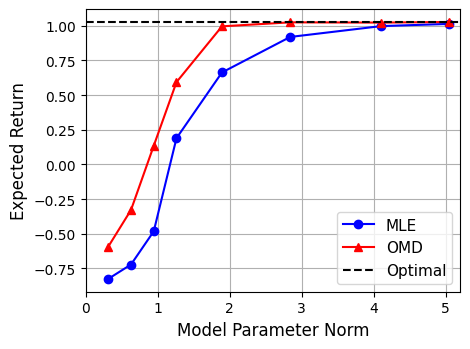

In [ ]:
idx = np.array([1, 2, 3, 4, 6, 9, 13, 16])
plt.plot(norm_bound_list[idx], Js_mle_mean[idx], 'o-', c='b', label='MLE', markersize=6)
plt.plot(norm_bound_list[idx], Js_omd_mean[idx], '^-', c='r', label='OMD', markersize=6)
plt.plot((0, 5.2), (optimal_value, optimal_value), '--', c='black', label='Optimal')
plt.xlim(0, 5.2)
plt.ylabel('Expected Return')
plt.xlabel('Model Parameter Norm')
plt.legend()
plt.tight_layout()
plt.savefig('misspec_tab.pdf')

## Comparing $Q^*$ approximations errors and error bounds


In [ ]:
start = time.time()
norm_bound_list = np.linspace(0, 6, 20)
num_seeds = 10
headers = ["Seed", "Q", "Policy", "p_\\theta", "r_\\theta", "J", "\|Q-B^true Q\|^2", "Q-B^\\theta Q", "grad\|Q-B^\\theta Q\|^2"]
all_errors_pr = []
all_bounds_pr = []
all_q_mle_approx = []
all_bounds_mle_gap = []

for i, norm_bound in enumerate(norm_bound_list):
  results = []
  for j, seed in enumerate(range(1, num_seeds+1)):
    kwargs['seed'] = seed
    kwargs['norm_bound'] = norm_bound
    kwargs['optimizer'] = padam
    kwargs['lr_func'] = 0.01
    kwargs['agent_type'] = 'mle'
    
    rngs = jax.random.split(jax.random.PRNGKey(seed), 3)
    initial_values = (
      jax.random.uniform(rngs[0], true_reward.shape),
      (jax.random.uniform(rngs[1], true_transition.shape), 
      jax.random.uniform(rngs[2], true_reward.shape))
    )

    solution = implicit_ecp(objective_bellman, equality_constraints, initial_values, **kwargs)
    # solution = implicit_ecp(objective_returns, equality_constraints, initial_values, **kwargs)

    results.append([
      seed,
      solution[0], 
      softmax((1. / temperature) * solution[0]), 
      softmax((1. / temperature) * solution[1][0]), 
      solution[1][1], 
      objective_returns(*solution),
      objective_bellman(*solution),
      equality_constraints(*solution),
      grad_constraints(*solution)
    ])
    
  print('Done {}/{} norm_bounds'.format(i+1, len(norm_bound_list)))
  errors_pr = list(map(lambda x: [jnp.max(jnp.sum(jnp.abs(x[3] - true_transition), axis=-1)).item(),
                                  jnp.max(jnp.abs(x[4] - true_reward)).item()], results))
  errors_pr_means = np.mean(errors_pr, 0)
  errors_pr_stderrs = np.std(errors_pr, 0) / np.sqrt(len(errors_pr))
  all_errors_pr.append([errors_pr_means, errors_pr_stderrs])
  
  bounds_pr = list(map(lambda x: [jnp.max(jnp.abs(x[4] - true_reward)).item() / (
      1 - true_discount) + true_discount * jnp.max(jnp.abs(true_reward)) * jnp.max(
          jnp.sum(jnp.abs(x[3] - true_transition), axis=-1)).item() / (2 * (1 - true_discount) ** 2)], results))
  bounds_pr_means = np.mean(bounds_pr, 0)
  bounds_pr_stderrs = np.std(bounds_pr, 0) / np.sqrt(len(bounds_pr))
  all_bounds_pr.append([bounds_pr_means, bounds_pr_stderrs])
  
  q_mle_approx = list(map(lambda x: [jnp.max(jnp.abs(Q_opt - x[1])).item()], results))
  q_mle_approx_means = np.mean(q_mle_approx, 0)
  q_mle_approx_stderrs = np.std(q_mle_approx, 0) / np.sqrt(len(q_mle_approx))
  all_q_mle_approx.append([q_mle_approx_means, q_mle_approx_stderrs])

  bounds_mle_gap = list(map(lambda x: [x[0][0] - x[1][0]], zip(bounds_pr, q_mle_approx)))
  bounds_mle_gap_means = np.mean(bounds_mle_gap, 0)
  bounds_mle_gap_stderrs = np.std(bounds_mle_gap, 0) / np.sqrt(len(bounds_mle_gap))
  all_bounds_mle_gap.append([bounds_mle_gap_means, bounds_mle_gap_stderrs])

print('Done in {:.2f} minutes'.format((time.time() - start) / 60))

Done 1/20 norm_bounds
Done 2/20 norm_bounds
Done 3/20 norm_bounds
Done 4/20 norm_bounds
Done 5/20 norm_bounds
Done 6/20 norm_bounds
Done 7/20 norm_bounds
Done 8/20 norm_bounds
Done 9/20 norm_bounds
Done 10/20 norm_bounds
Done 11/20 norm_bounds
Done 12/20 norm_bounds
Done 13/20 norm_bounds
Done 14/20 norm_bounds
Done 15/20 norm_bounds
Done 16/20 norm_bounds
Done 17/20 norm_bounds
Done 18/20 norm_bounds
Done 19/20 norm_bounds
Done 20/20 norm_bounds
Done in 2.84 minutes


In [ ]:
start = time.time()
norm_bound_list = np.linspace(0, 6, 20)
num_seeds = 10
headers = ["Seed", "Q", "Policy", "p_\\theta", "r_\\theta", "J", "\|Q-B^true Q\|^2", "Q-B^\\theta Q", "grad\|Q-B^\\theta Q\|^2"]
all_errors = []
all_q_omd_approx = []
all_bounds = []
all_bounds_omd_gap = []

for i, norm_bound in enumerate(norm_bound_list):
  results = []
  for j, seed in enumerate(range(1, num_seeds+1)):
    kwargs['seed'] = seed
    kwargs['norm_bound'] = norm_bound
    kwargs['optimizer'] = padam
    kwargs['lr_func'] = 0.01
    kwargs['agent_type'] = 'omd'
    
    rngs = jax.random.split(jax.random.PRNGKey(seed), 3)
    initial_values = (
      jax.random.uniform(rngs[0], true_reward.shape),
      (jax.random.uniform(rngs[1], true_transition.shape), 
      jax.random.uniform(rngs[2], true_reward.shape))
    )

    solution = implicit_ecp(objective_bellman, equality_constraints, initial_values, **kwargs)
    # solution = implicit_ecp(objective_returns, equality_constraints, initial_values, **kwargs)
    
    results.append([
      seed,
      solution[0], 
      softmax((1. / temperature) * solution[0]), 
      softmax((1. / temperature) * solution[1][0]), 
      solution[1][1], 
      objective_returns(*solution),
      objective_bellman(*solution),
      equality_constraints(*solution),
      grad_constraints(*solution)
    ])
    
  print('Done {}/{} bounds'.format(i+1, len(norm_bound_list)))
  errors = list(map(lambda x: [jnp.max(jnp.abs(smooth_bellman_optimality_operator(x[1], (
      true_transition, true_reward, true_discount, temperature)) - smooth_bellman_optimality_operator(
          x[1], (x[3], x[4], true_discount, temperature)))).item()], results))
  errors_means = np.mean(errors, 0)
  errors_stderrs = np.std(errors, 0) / np.sqrt(len(errors))
  all_errors.append([errors_means, errors_stderrs])
  
  bounds = list(map(lambda x: [jnp.max(jnp.abs(smooth_bellman_optimality_operator(x[1], (
      true_transition, true_reward, true_discount, temperature)) - smooth_bellman_optimality_operator(
          x[1], (x[3], x[4], true_discount, temperature)))).item() / (1 - true_discount)], results))
  bounds_means = np.mean(bounds, 0)
  bounds_stderrs = np.std(bounds, 0) / np.sqrt(len(bounds))
  all_bounds.append([bounds_means, bounds_stderrs])
  
  q_omd_approx = list(map(lambda x: [jnp.max(jnp.abs(Q_opt - x[1])).item()], results))
  q_omd_approx_means = np.mean(q_omd_approx, 0)
  q_omd_approx_stderrs = np.std(q_omd_approx, 0) / np.sqrt(len(q_omd_approx))
  all_q_omd_approx.append([q_omd_approx_means, q_omd_approx_stderrs])

  bounds_omd_gap = list(map(lambda x: [x[0][0] - x[1][0]], zip(bounds, q_omd_approx)))
  bounds_omd_gap_means = np.mean(bounds_omd_gap, 0)
  bounds_omd_gap_stderrs = np.std(bounds_omd_gap, 0) / np.sqrt(len(bounds_omd_gap))
  all_bounds_omd_gap.append([bounds_omd_gap_means, bounds_omd_gap_stderrs])
  
print('Done in {:.2f} minutes'.format((time.time() - start) / 60))

Done 1/20 bounds
Done 2/20 bounds
Done 3/20 bounds
Done 4/20 bounds
Done 5/20 bounds
Done 6/20 bounds
Done 7/20 bounds
Done 8/20 bounds
Done 9/20 bounds
Done 10/20 bounds
Done 11/20 bounds
Done 12/20 bounds
Done 13/20 bounds
Done 14/20 bounds
Done 15/20 bounds
Done 16/20 bounds
Done 17/20 bounds
Done 18/20 bounds
Done 19/20 bounds
Done 20/20 bounds
Done in 5.05 minutes


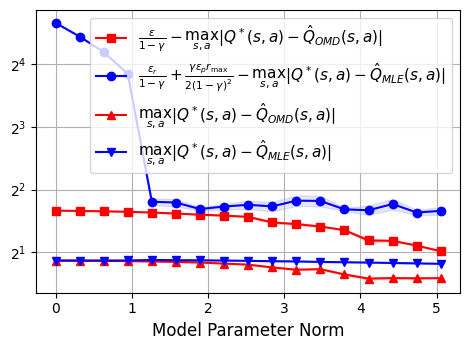

In [ ]:
idx = 17
plt.figure()

all_bounds_omd_gap_means = np.array(list(map(lambda x: x[0][0], all_bounds_omd_gap[:idx])))
all_bounds_omd_gap_stderrs = np.array(list(map(lambda x: x[1][0], all_bounds_omd_gap[:idx])))
plt.plot(norm_bound_list[:idx], all_bounds_omd_gap_means, 's-', c='r', label=r'$\frac{\epsilon}{1-\gamma} - \max_{s,a}|Q^*(s,a) - \hat{Q}_{OMD}(s,a)|$', markersize=6)
plt.fill_between(norm_bound_list[:idx], 
                 all_bounds_omd_gap_means + all_bounds_omd_gap_stderrs,
                 all_bounds_omd_gap_means - all_bounds_omd_gap_stderrs, 
                 color='r', alpha=0.1)

all_bounds_mle_gap_means = np.array(list(map(lambda x: x[0][0], all_bounds_mle_gap[:idx])))
all_bounds_mle_gap_stderrs = np.array(list(map(lambda x: x[1][0], all_bounds_mle_gap[:idx])))
plt.plot(norm_bound_list[:idx], all_bounds_mle_gap_means, 'o-', c='b', label=r'$\frac{\epsilon_r}{1-\gamma} + \frac{\gamma \epsilon_p r_{\max}}{2(1-\gamma)^2} - \max_{s,a}|Q^*(s,a) - \hat{Q}_{MLE}(s,a)|$', markersize=6)
plt.fill_between(norm_bound_list[:idx], 
                 all_bounds_mle_gap_means + all_bounds_mle_gap_stderrs,
                 all_bounds_mle_gap_means - all_bounds_mle_gap_stderrs, 
                 color='b', alpha=0.1)

all_q_omd_approx_means = np.array(list(map(lambda x: x[0][0], all_q_omd_approx[:idx])))
all_q_omd_approx_stderrs = np.array(list(map(lambda x: x[1][0], all_q_omd_approx[:idx])))
plt.plot(norm_bound_list[:idx], all_q_omd_approx_means, '^-',  c='r', label=r'$\max_{s,a}|Q^*(s,a) - \hat{Q}_{OMD}(s,a)|$', markersize=6)
plt.fill_between(norm_bound_list[:idx], 
                 all_q_omd_approx_means + all_q_omd_approx_stderrs,
                 all_q_omd_approx_means - all_q_omd_approx_stderrs, 
                 color='r', alpha=0.1)

all_q_mle_approx_means = np.array(list(map(lambda x: x[0][0], all_q_mle_approx[:idx])))
all_q_mle_approx_stderrs = np.array(list(map(lambda x: x[1][0], all_q_mle_approx[:idx])))
plt.plot(norm_bound_list[:idx], all_q_mle_approx_means, 'v-',  c='b', label=r'$\max_{s,a}|Q^*(s,a) - \hat{Q}_{MLE}(s,a)|$', markersize=6)
plt.fill_between(norm_bound_list[:idx], 
                 all_q_mle_approx_means + all_q_mle_approx_stderrs,
                 all_q_mle_approx_means - all_q_mle_approx_stderrs, 
                 color='b', alpha=0.1)

plt.yscale('log', basey=2)
plt.xlabel('Model Parameter Norm')
plt.legend()
plt.tight_layout()
plt.savefig('tightness_bound_tab_with_q_approx.pdf')

## Analysis of the IFT sensitivity to the inner loop solution and the Jacobian

In [ ]:
# code from https://github.com/gehring/fax/blob/master/fax/implicit/twophase.py
# we only modify two_phase_rev function to substitute the Jacobian with I

from fax.implicit.twophase import default_convergence_test, default_solver

import functools
import logging
import operator

import jax
#import jax.numpy as np

from fax import converge
from fax import loop

logger = logging.getLogger(__name__)

_add = functools.partial(jax.tree_multimap, operator.add)


@functools.partial(jax.custom_vjp, nondiff_argnums=(0, 3))
def two_phase_solve_identity(param_func, init_xs, params, solvers=()):
    """ Create an implicit function of the parameters and 
        define its APPROXIMATE VJP rule.
    Args:
        param_func: A "parametric" operator (i.e., callable) taking in some
            parameters and returning a function for which we seek a
            fixed-point.
        init_xs: The initial "guess" for the fixed-point of
            `param_func(params)(x) = x`.
        params: The parameters to use when evaluating `param_func`.
        solvers (optional): A sequence of solvers to be used for solving for
            the different fixed-point required for solving the given parametric
            fixed-point and its derivatives. Specifying solvers is optional. If
            a `None` value is encountered in the sequence, the default solver
            will be used.
            The first solver in the sequence is used to solve for the
            parametric fixed point and every subsequent solver is used to
            compute the derivatives of increasing order. For example,
            `solvers[1]` is the solver used when computing the first order
            while `solvers[2]` would be used to solve for the second order
            derivatives.
            Each solver should be a callable taking in a parametric function
            (i.e., a callable which returns a callable) for which we seek a
            fixed-point, the initial guess, and the parameters to use. Except
            for the first solvers, the function given as first argument will
            not be `param_func` but a VJP function derived from `param_func`.
            Formally, a solver is expected to have the following signature:
            ```
            ((b -> (a -> a)) -> a -> b) -> a
            ```
            For `solver[0]`, a is simply the type of `init_xs`, b is the type
            of `param`.
    Returns:
        The solution to the parametric fixed-point with reverse differentiation
        rules defined using the implicit function theorem.
    """

    # If no solver is given or if None is found in its place, use the default
    # fixed-point iteration solver.
    if solvers and solvers[0] is not None:
        fwd_solver = solvers[0]
    else:
        fwd_solver = default_solver()

    return fwd_solver(param_func, init_xs, params)


def two_phase_fwd(param_func, init_xs, params, solvers):
    sol = two_phase_solve_identity(param_func, init_xs, params, solvers)
    return sol, (sol, params)


# we only change this part of code
def two_phase_rev_identity(param_func, solvers, res, sol_bar):
    sol, params = res
    _, dparam_vjp = jax.vjp(lambda p: param_func(p)(sol), params)
    return jax.tree_map(jnp.zeros_like, sol), dparam_vjp(sol_bar)[0]


# def two_phase_rev(param_func, solvers, res, sol_bar):

#     def param_dfp_fn(packed_params):
#         v, p, dvalue = packed_params
#         _, fp_vjp_fn = jax.vjp(lambda x: param_func(p)(x), v)

#         def dfp_fn(dout):
#             dout = _add(fp_vjp_fn(dout)[0], dvalue)
#             return dout

#         return dfp_fn

#     sol, params = res
#     dsol = two_phase_solve(param_dfp_fn,
#                            sol_bar,
#                            (sol, params, sol_bar),
#                            solvers[1:])
#     _, dparam_vjp = jax.vjp(lambda p: param_func(p)(sol), params)
#     return jax.tree_map(np.zeros_like, sol), dparam_vjp(dsol)[0]
    

two_phase_solve_identity.defvjp(two_phase_fwd, two_phase_rev_identity)

In [ ]:
start = time.time()
std_list = np.logspace(-3, 0.5, 30)
num_seeds = 10
Js_inv_jac = np.zeros((len(std_list), num_seeds))
Bs_inv_jac = np.zeros((len(std_list), num_seeds))
Js_no_inv_jac = np.zeros((len(std_list), num_seeds))
Bs_no_inv_jac = np.zeros((len(std_list), num_seeds))

kwargs = {'max_iter': 10000, 'lr_func': 0.01, 'optimizer': optimizers.adam}

for i, std in enumerate(std_list):
  for j, seed in enumerate(range(1, num_seeds+1)):
    kwargs['seed'] = seed
    kwargs['std'] = std
    
    rngs = jax.random.split(jax.random.PRNGKey(seed), 3)
    initial_values = (
      jax.random.uniform(rngs[0], true_reward.shape),
      (jax.random.uniform(rngs[1], true_transition.shape), 
      jax.random.uniform(rngs[2], true_reward.shape))
    )

    solution = implicit_ecp(objective_bellman, equality_constraints, initial_values, **kwargs)
    Js_inv_jac[i,j] = objective_returns(solution[0], solution[1]).item()
    Bs_inv_jac[i,j] = -objective_bellman(solution[0], solution[1]).item()

    solution = implicit_ecp(objective_bellman, equality_constraints, initial_values, 
                          **kwargs, constraints_solver=two_phase_solve_identity)
    Js_no_inv_jac[i,j] = objective_returns(solution[0], solution[1]).item()
    Bs_no_inv_jac[i,j] = -objective_bellman(solution[0], solution[1]).item()
  
  print('Done {}/{} stds'.format(i+1, len(std_list)))
print('Done in {:.2f} minutes'.format((time.time() - start) / 60))

Done 1/30 stds
Done 2/30 stds
Done 3/30 stds
Done 4/30 stds
Done 5/30 stds
Done 6/30 stds
Done 7/30 stds
Done 8/30 stds
Done 9/30 stds
Done 10/30 stds
Done 11/30 stds
Done 12/30 stds
Done 13/30 stds
Done 14/30 stds
Done 15/30 stds
Done 16/30 stds
Done 17/30 stds
Done 18/30 stds
Done 19/30 stds
Done 20/30 stds
Done 21/30 stds
Done 22/30 stds
Done 23/30 stds
Done 24/30 stds
Done 25/30 stds
Done 26/30 stds
Done 27/30 stds
Done 28/30 stds
Done 29/30 stds
Done 30/30 stds
Done in 13.61 minutes


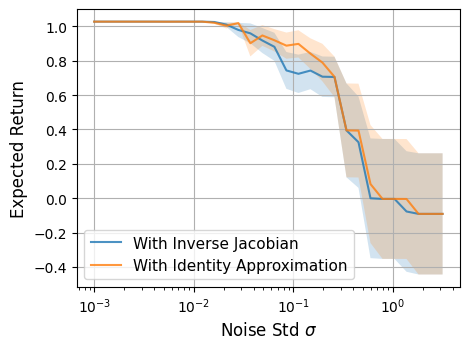

In [ ]:
m, s = Js_inv_jac.mean(1), Js_inv_jac.std(1)
plt.plot(std_list, m, label='With Inverse Jacobian', alpha=0.8)
plt.fill_between(std_list, m - 0.3 * s, m + 0.3 * s, alpha=0.2)

m, s = Js_no_inv_jac.mean(1), Js_no_inv_jac.std(1)
plt.plot(std_list, m, label='With Identity Approximation', alpha=0.8)
plt.fill_between(std_list, m - 0.3 * s, m + 0.3 * s, alpha=0.2)

plt.xscale('log')
plt.legend()
plt.ylabel('Expected Return')
plt.xlabel(r'Noise Std $\sigma$')
plt.yticks()
plt.xticks()

plt.tight_layout()
plt.savefig('ift_approx_tab.pdf')